# TinyBench Eval Results Analysis

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams.update({"figure.dpi": 120, "figure.facecolor": "white"})

RESULTS_DIR = Path("../eval_results")

## 1. Load all results

In [2]:
dfs = []
for p in sorted(RESULTS_DIR.glob("*.csv")):
    dfs.append(pd.read_csv(p))

df = pd.concat(dfs, ignore_index=True)

# Normalize Result column and compute score: CORRECT=1, PARTIAL=0.5, INCORRECT=0
df["result_norm"] = df["Result"].str.strip().str.upper()
df["score"] = df["result_norm"].map({"CORRECT": 1.0, "PARTIAL": 0.5, "INCORRECT": 0.0}).fillna(0.0)

# Warn about rows missing key columns
required = ["Model", "Dataset", "Injector"]
missing = df[required].isna().any(axis=1)
if missing.sum() > 0:
    print(f"WARNING: {missing.sum()} rows missing {required} — dropping them.")
    print(df[missing][["Model", "Dataset", "Injector"]].to_string())
    print()
    df = df.dropna(subset=required)

print(f"{len(df)} total eval results")
print(f"Result breakdown: {df['result_norm'].value_counts().to_dict()}")
print(f"Models: {sorted(df['Model'].unique())}")
print(f"Datasets: {sorted(df['Dataset'].unique())}")
print(f"Injectors: {sorted(df['Injector'].unique())}")
print(f"Overall score: {df['score'].mean():.1%}")
df.head()

175 total eval results
Result breakdown: {'INCORRECT': 113, 'CORRECT': 55, 'PARTIAL': 7}
Models: ['claude-opus-4-6', 'claude-sonnet-4-5-20250929', 'deepseek-r1:8b', 'gpt-4o', 'gpt-4o-mini', 'llama3.2:3b', 'qwen2.5:7b']
Datasets: ['bike_sharing_100', 'bike_sharing_1000', 'bike_sharing_500', 'vgsales_100', 'vgsales_1000', 'vgsales_500']
Injectors: ['bad_rows_injection', 'changepoint_injection', 'heteroskedastic_injection', 'name_swap_injection', 'simpsons_paradox_injection']
Overall score: 33.4%


,Model,Dataset,Injector,Question,Expected Answer,Model Answer,Result,Would evaluating a predictive model on held-out set reveal whether this phenomena was recovered?,result_norm,score
0,llama3.2:3b,bike_sharing_100,simpsons_paradox_injection,Between period A and period B (defined by befo...,IMPROVED,WORSENED,INCORRECT,NaN,INCORRECT,0.0
1,llama3.2:3b,bike_sharing_100,name_swap_injection,Which columns matter most for understanding or...,"var_gkmp, var_wb8o, m_lv2o, feat_jphe, field_j9up","After analyzing the data, I've identified the ...",INCORRECT,NaN,INCORRECT,0.0
2,llama3.2:3b,bike_sharing_100,bad_rows_injection,Which column should the rule be based on to ex...,_check_flag,The best answer is B,INCORRECT,NaN,INCORRECT,0.0
3,llama3.2:3b,bike_sharing_100,heteroskedastic_injection,"Between groups 15 and 12 (defined by hr), whic...",15,"Based on the data, between groups 15 and 12, g...",CORRECT,NaN,CORRECT,1.0
4,llama3.2:3b,bike_sharing_100,changepoint_injection,"Should the model be retrained? If YES, return ...","YES, 32","Based on the provided data, I would recommend ...",PARTIAL,NaN,PARTIAL,0.5


## 2. Score by model

In [3]:
model_stats = (
    df.groupby("Model")
    .agg(
        score=("score", "mean"),
        correct=("result_norm", lambda x: (x == "CORRECT").sum()),
        partial=("result_norm", lambda x: (x == "PARTIAL").sum()),
        incorrect=("result_norm", lambda x: (x == "INCORRECT").sum()),
        total=("score", "count"),
    )
    .sort_values("score", ascending=False)
)
model_stats

,score,correct,partial,incorrect,total
Model,,,,,
claude-opus-4-6,0.58,14,1,10,25
claude-sonnet-4-5-20250929,0.52,13,0,12,25
gpt-4o,0.48,12,0,13,25
gpt-4o-mini,0.28,6,2,17,25
deepseek-r1:8b,0.18,4,1,20,25
qwen2.5:7b,0.16,4,0,21,25
llama3.2:3b,0.14,2,3,20,25


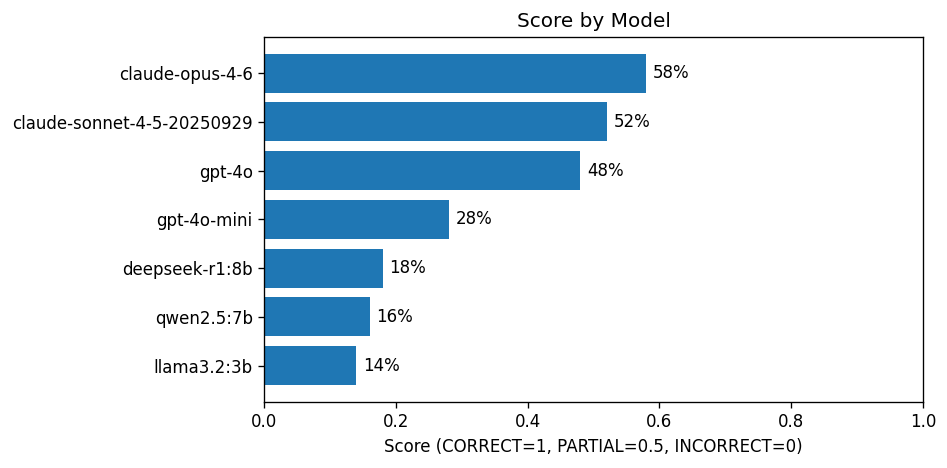

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))
model_sorted = model_stats.sort_values("score")
bars = ax.barh(model_sorted.index, model_sorted["score"])
ax.set_xlim(0, 1)
ax.set_xlabel("Score (CORRECT=1, PARTIAL=0.5, INCORRECT=0)")
ax.set_title("Score by Model")
for bar, v in zip(bars, model_sorted["score"]):
    ax.text(v + 0.01, bar.get_y() + bar.get_height() / 2, f"{v:.0%}", va="center")
plt.tight_layout()
plt.show()

## 3. Score by injector type

In [5]:
inj_acc = (
    df.groupby("Injector")["score"]
    .agg(["mean", "count"])
    .rename(columns={"mean": "score", "count": "total"})
    .sort_values("score", ascending=False)
)
inj_acc

,score,total
Injector,,
heteroskedastic_injection,0.714286,21
changepoint_injection,0.488095,42
bad_rows_injection,0.404762,42
simpsons_paradox_injection,0.214286,28
name_swap_injection,0.000000,42


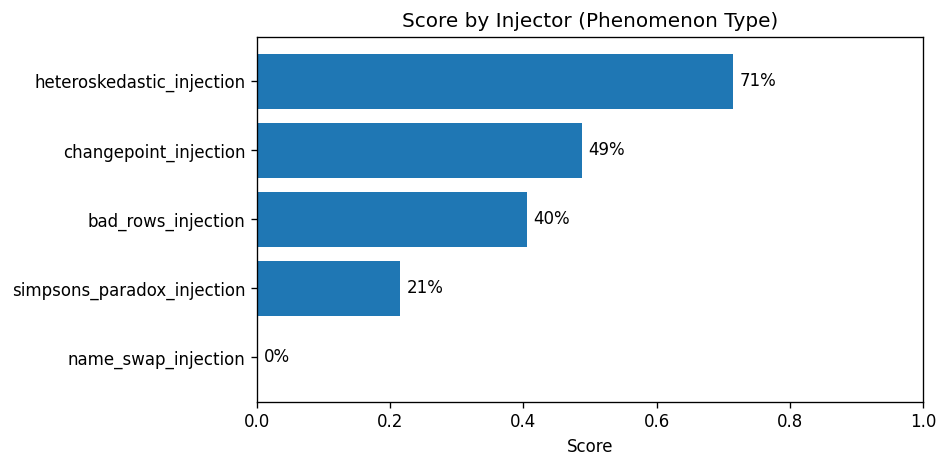

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
inj_sorted = inj_acc.sort_values("score")
bars = ax.barh(inj_sorted.index, inj_sorted["score"])
ax.set_xlim(0, 1)
ax.set_xlabel("Score")
ax.set_title("Score by Injector (Phenomenon Type)")
for bar, v in zip(bars, inj_sorted["score"]):
    ax.text(v + 0.01, bar.get_y() + bar.get_height() / 2, f"{v:.0%}", va="center")
plt.tight_layout()
plt.show()

## 4. Model x Injector heatmap

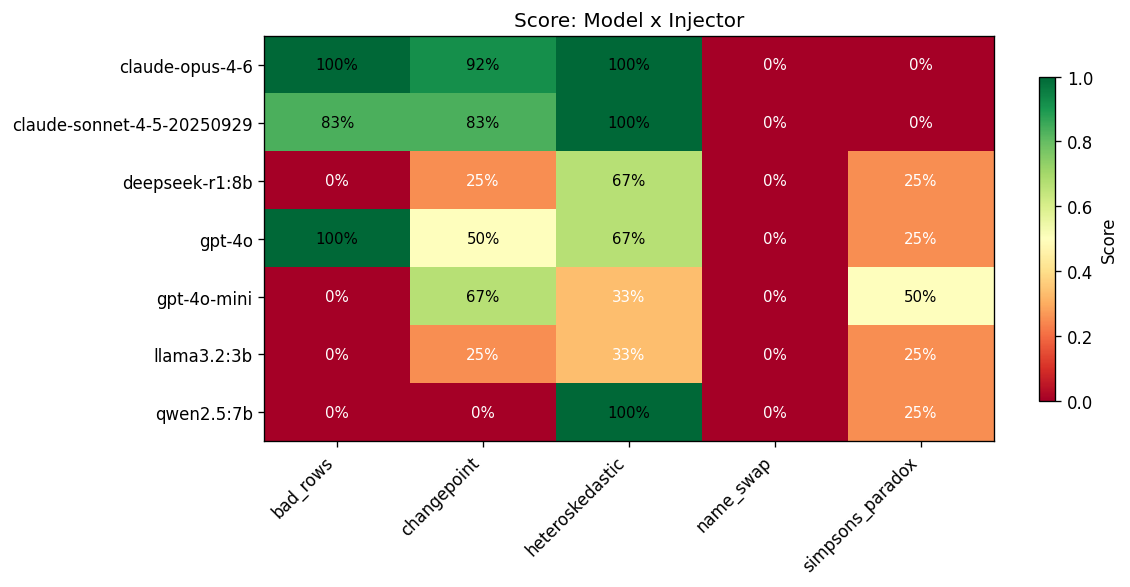

In [7]:
pivot = df.pivot_table(index="Model", columns="Injector", values="score", aggfunc="mean")

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(pivot.values, cmap="RdYlGn", vmin=0, vmax=1, aspect="auto")

ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels([c.replace("_injection", "") for c in pivot.columns], rotation=45, ha="right")
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)

for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        v = pivot.values[i, j]
        if not np.isnan(v):
            ax.text(j, i, f"{v:.0%}", ha="center", va="center", fontsize=9,
                    color="white" if v < 0.4 else "black")

ax.set_title("Score: Model x Injector")
fig.colorbar(im, ax=ax, label="Score", shrink=0.8)
plt.tight_layout()
plt.show()

## 5. Model x Dataset heatmap

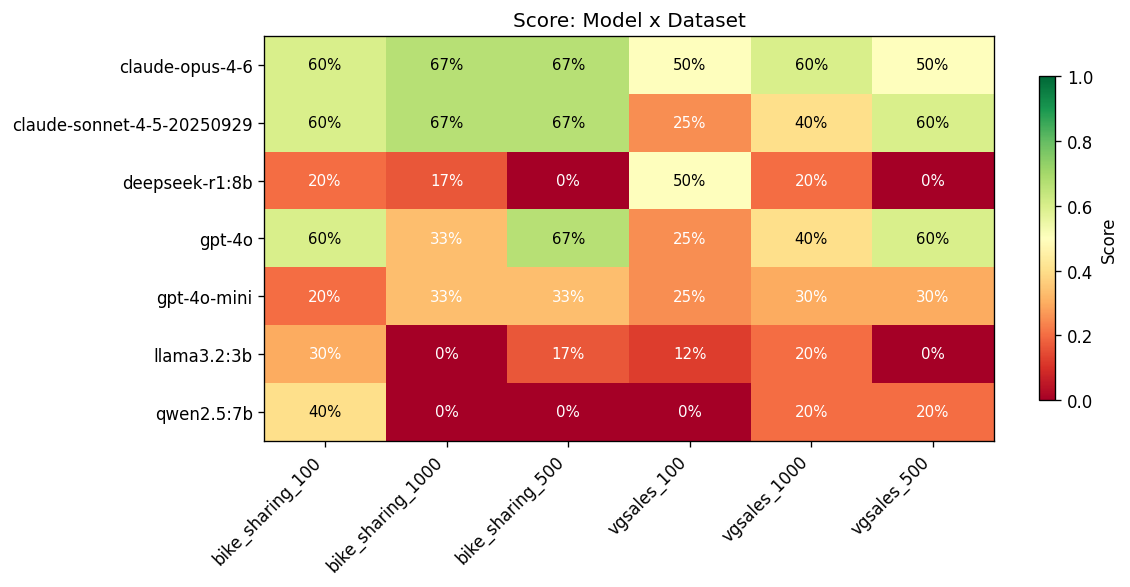

In [8]:
pivot_ds = df.pivot_table(index="Model", columns="Dataset", values="score", aggfunc="mean")

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(pivot_ds.values, cmap="RdYlGn", vmin=0, vmax=1, aspect="auto")

ax.set_xticks(range(len(pivot_ds.columns)))
ax.set_xticklabels(pivot_ds.columns, rotation=45, ha="right")
ax.set_yticks(range(len(pivot_ds.index)))
ax.set_yticklabels(pivot_ds.index)

for i in range(len(pivot_ds.index)):
    for j in range(len(pivot_ds.columns)):
        v = pivot_ds.values[i, j]
        if not np.isnan(v):
            ax.text(j, i, f"{v:.0%}", ha="center", va="center", fontsize=9,
                    color="white" if v < 0.4 else "black")

ax.set_title("Score: Model x Dataset")
fig.colorbar(im, ax=ax, label="Score", shrink=0.8)
plt.tight_layout()
plt.show()

## 6. Wrong & partial answers detail

In [9]:
not_correct = df[df["result_norm"] != "CORRECT"]
print(f"{len(not_correct)} non-correct answers ({(not_correct['result_norm'] == 'PARTIAL').sum()} partial, {(not_correct['result_norm'] == 'INCORRECT').sum()} incorrect)\n")
for _, r in not_correct.iterrows():
    answer_preview = str(r["Model Answer"])[:150]
    label = r["result_norm"]
    print(f"[{label}] [{r['Model']}] {r['Dataset']}/{r['Injector']}")
    print(f"  expected: {r['Expected Answer']}")
    print(f"  got:      {answer_preview}")
    print()

120 non-correct answers (7 partial, 113 incorrect)

[INCORRECT] [llama3.2:3b] bike_sharing_100/simpsons_paradox_injection
  expected: IMPROVED
  got:      WORSENED

[INCORRECT] [llama3.2:3b] bike_sharing_100/name_swap_injection
  expected: var_gkmp, var_wb8o, m_lv2o, feat_jphe, field_j9up
  got:      After analyzing the data, I've identified the top 5 features that matter most for understanding or predicting cnt. Here they are, along with a brief j

[INCORRECT] [llama3.2:3b] bike_sharing_100/bad_rows_injection
  expected: _check_flag
  got:      The best answer is B

[PARTIAL] [llama3.2:3b] bike_sharing_100/changepoint_injection
  expected: YES, 32
  got:      Based on the provided data, I would recommend retraining the model. The reason for this decision lies in the rapid growth and variation in values as w

[INCORRECT] [llama3.2:3b] bike_sharing_500/name_swap_injection
  expected: var_gkmp, var_wb8o, m_lv2o, feat_jphe, field_03nh
  got:      Based on the provided data, I've analyzed 